In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
#%cd /gdrive/.shortcut-targets-by-id/18Q4R_VFnBCTjQqQ4OPzTOkCu4aYKEmfL/project

In [4]:
%cd ../gdrive/My\ Drive/project

/gdrive/My Drive/project


In [5]:
!pip install -r classifier/requirements_old.txt
!pip install tensorflow==1.14.0
!pip install keras==2.2.0

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 83.1MB 59kB/s 
     |████████████████████████████████| 17.3MB 198kB/s 
     |████████████████████████████████| 25.0MB 125kB/s 
     |████████████████████████████████| 30.6MB 77kB/s 
     |████████████████████████████████| 26.3MB 82kB/s 
     |████████████████████████████████| 10.1MB 14.9MB/s 
     |████████████████████████████████| 6.7MB 30.3MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 3.1MB 40.9MB/s 
  Created wheel for mahotas: filename=mahotas-1.4.8-cp36-cp36m-linux_x86_64.whl size=4265570 sha256=8bc6551f7baa337574a86dce742e2d2a17fb14fff31f5dd1ed231586c5f6208e
  Stored in directory: /root/.cache/pip/wheels/3e/8b/93/690deca49a46242df274db70dbef26c0a6fa86e378b677e1ab
Successfully built mahotas
ERROR: xarray 0.15.1 has requirement pandas>=0.25, but you'll have pandas 0.24.1 which is incompatible.
ERROR: umap-learn 0.4.6 has requirement nu

     |████████████████████████████████| 109.2MB 60kB/s 
     |████████████████████████████████| 491kB 28.2MB/s 
     |████████████████████████████████| 3.2MB 41.1MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 1.12.2
    Uninstalling tensorboard-1.12.2:
      Successfully uninstalled tensorboard-1.12.2
  Found existing installation: tensorflow 1.12.2
    Uninstalling tensorflow-1.12.2:
      Successfully uninstalled tensorflow-1.12.2
     |████████████████████████████████| 307kB 2.8MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
ERROR: tensorflow 1.14.0 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.2 which is incompatible.
ERROR: tensorflow 1.14.0 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.1 which is incompatible.
  Found existing installa

In [6]:
import os
import sys
sys.path.insert(0, os.getcwd()) # add current working directory to pythonpath

import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from classifier.utils import config
from classifier.utils.data import get_prediction_score
from classifier.models import feature_extraction
import pickle
import warnings
import argparse

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [ ]:
def resize_image(img, img_size):
    """Pad and Resize image to a fixed size (img_size, img_size)
    :param img: ndarray, BGR image
    :param img_size: int, size to resize images.
    :return img_resized: padded and resized image
    """
    
    # pad image to the max dimension
    top = (max(img.shape[:2]) - img.shape[0])//2
    bottom = max(img.shape[:2]) - img.shape[0] - top
    left = (max(img.shape[:2]) - img.shape[1])//2
    right = max(img.shape[:2]) - img.shape[1] - left
    img_padded = cv2.copyMakeBorder(img, top, bottom, left, right,cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    # resize image
    img_resized = cv2.resize(img_padded, (img_size, img_size))
    return img_resized
    
def prepare_dataset(input_path, img_size=None, keypoint_detector=None):
    """Process images of different classes and extract labels and global features of images
    :param input_path: str, path to the a dataset folder, which should have the below structure:
        input_path
            |---class_1
            |---class_2
            ...
            |---class_N
    : img_size: int, size to resize images. If None, resize will not be performed.
    :return global_features: list, contains global features of images
    :return label: list, contains labels (or classes) of images
    """
    
    if keypoint_detector is None:
        keypoint_detector = cv2.xfeatures2d.SURF_create()
 
    global_features = []
    keypoints_features = []
    labels = []
    folder_list = os.listdir(input_path)
    for folder in folder_list:
        print('Processing: ' + folder)       
        folder_path = os.path.join(input_path, folder)
        file_list = os.listdir(folder_path)
        for filename in file_list:
            img = cv2.imread(os.path.join(folder_path, filename))[:, :, :3] # ignore alpha channel
            if img_size is not None:
                img = resize_image(img, img_size)
            global_feature = feature_extraction.extract_global_features(img)
            global_features.append(global_feature)
            labels.append(folder)
            
            _, keypoint_descriptors = feature_extraction.extract_keypoints(keypoint_detector, img)
            keypoints_features.append(keypoint_descriptors)
                   
    return np.array(global_features), keypoints_features, np.array(labels) 


def train_model(model, X_train, y_train, parameters, n_splits=3):
    """Train model with Grid-search cross validation to find the best hyperparameter
    :param model: Scikit-learn estimator
    :param X_train: trainset features
    :param y_train: trainset label
    :param parameters: dict, key is hyper parameter name and value is a list of hyper parameter values
    :return best_estimator: Scikit-learn estimator with the best hyper parameter
    :return best_score: best accuracy score
    :return best_param: dict, best hyper parameter
    """
    
    splits = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0).split(X=X_train, y=y_train)
    
    clf = GridSearchCV(model, parameters, cv=splits, scoring=make_scorer(accuracy_score))
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')  # disable the warning on default optimizer
        clf.fit(X_train, y_train)

    return clf.best_estimator_, clf.best_score_, clf.best_params_


def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Evaluate model on testset
    :param model: Scikit-learn estimator
    :param X_train: trainset features
    :param y_train: trainset label
    :param X_test: testset features
    :param y_test: testset label
    :param parameters: dict, key is hyper parameter name and value is a list of hyper parameter values
    :return model: Scikit-learn estimator, fitted on the whole trainset
    :return y_predict: prediction on test set
    :return scores: dict, evaluation metrics on test set
    """
    
    # Refit the model on the whole train set
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')  # disable the warning on default optimizer
        model.fit(X_train, y_train)
        
    # Evaluate on test set
    y_predict = model.predict(X_test)
    scores = None
    if y_test is not None:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # disable the warning on f1-score with not all labels
            scores = get_prediction_score(y_test, y_predict)

    return model, y_predict, scores


def build_base_models(X_train, y_train):
    """Train and evaluate different base models. "Base" means the model is not a stacking model. 
    :param X_train: trainset features
    :param y_train: trainset label
    :return fitted_models: list, contains fitted Scikit-learn estimators
    :return model_names: list, names of fitted Scikit-learn estimators
    :return model_scores: list, contains scores on test set for fitted Scikit-learn estimators.
                    Each score is a dict of evaluation metrics
    """
    
    ########################
    # DEFINE BASE MODELS ###
    ########################
    models = []
    model_params = []
    model_names = []
    
    # Random forest model
    for n_estimators in [500, 1000, 2000]:
        for max_depth in [3, 5, 7]:
            models.append(RandomForestClassifier(max_features='sqrt', class_weight='balanced', random_state=0))
            model_params.append({'n_estimators':[n_estimators], 'max_depth':[max_depth]})
            model_names.append('Random Forest')   
    
    # Boosted Tree
    for n_estimators in [500, 1000, 2000]:
        for max_depth in [3, 5, 7]:
            for learning_rate in [0.01, 0.1]:
                models.append(GradientBoostingClassifier(subsample=0.7, max_features='sqrt', random_state=0))
                model_params.append({'n_estimators':[n_estimators], 'max_depth':[max_depth], 'learning_rate':[learning_rate]})
                model_names.append('Gradient Boosting Machine')
    
    # SVM
    for kernel in ['linear', 'rbf']:
        for C in [1.0, 10.0, 100.0, 1000.0]:
                  #probability,     karnel       ,stopping the karnel, cache size ,class weight               
            models.append(SVC(probability=True, gamma='auto', tol=0.001, cache_size=200, class_weight='balanced',
random_state=0,
                              decision_function_shape='ovr'))
            model_params.append({'kernel':[kernel], 'C':[C]})
            model_names.append('Support Vector Machine')
    
    # Logistic regression model
    for penalty in ['l1', 'l2']:
        for C in [1.0, 10.0, 100.0, 1000.0]:
            models.append(linear_model.LogisticRegression(max_iter=500, solver='liblinear', multi_class='ovr',
                                                          class_weight='balanced', random_state=0))
            model_params.append({'penalty':[penalty], 'C':[C]})
            model_names.append('Logistic Regression')
        
    # KNN
    for n_neighbors in [5, 10, 15]:
        for weights in ['uniform', 'distance']:
            models.append(KNeighborsClassifier())
            model_params.append({'n_neighbors':[n_neighbors], 'weights':[weights]})
            model_names.append('K Nearest Neighbour')
            
    ##################################
    # TRAIN AND EVALUATE BASE MODELS #
    ##################################
    fitted_models = []
    model_scores = []
    for i in range(len(models)):
        print('Evaluating model {} of {}: {}'.format((i+1), len(models), model_names[i]))
        model = models[i]
        fitted_cv, _, _ = train_model(model=model, X_train=X_train, y_train=y_train, parameters=model_params[i])
        fitted_whole_set, _, score = evaluate_model(model=fitted_cv, X_train=X_train, y_train=y_train,
                                                    X_test=X_test, y_test=y_test)
        fitted_models.append(fitted_whole_set)
        model_scores.append(score)
        print(model_names[i], score)
        
    return fitted_models, model_names, model_scores


def build_stack_models(base_models, X_train, y_train):
    """Train and evaluate different stack models
    :param base_models: list, contains fitted base models, which are Scikit-learn estimators
    :param X_train: trainset features
    :param y_train: trainset label
    :return stack_fitted_models: list, contains fitted Scikit-learn estimators
    :return stack_model_names: list, names of fitted Scikit-learn estimators
    :return stack_model_scores: list, contains scores on test set for fitted Scikit-learn estimators.
                    Each score is a dict of evaluation metrics
    """
    
    ###############################
    ### PREPARE DATA FOR STACKING #
    ###############################
    print('Preparing data for model stacking')
    from sklearn.preprocessing import OneHotEncoder
    label_encoder = OneHotEncoder(categories='auto', sparse=False)
    label_encoder.fit(np.unique(y_train).reshape(-1, 1))
    nb_classes = len(label_encoder.categories_[0])
    
    # Get base models' prediction for test set: simply use the trained models to predict on test set
    X_test_stack = np.zeros([X_test.shape[0], len(base_models)*nb_classes])
    for i in range(len(base_models)):
        model = base_models[i]
        X_test_stack[:, i*nb_classes:(i+1)*nb_classes] = label_encoder.transform(model.predict(X_test).reshape(-1, 1))
            
    # Get base models' prediction for train set: use 3-fold split, train model on 2 parts and predict on 3rd part
    splits = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0).split(X=X_train, y=y_train)
    X_train_stack = np.zeros([X_train.shape[0], len(base_models)*nb_classes])
    for train_index, val_index in splits:
        # train and validation set
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, _ = y_train[train_index], y_train[val_index]

        # Fit model
        for i in range(len(base_models)):
            model = base_models[i]
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')  # disable the warning on default optimizer
                model.fit(X_tr, y_tr)
            X_train_stack[val_index, i*nb_classes:(i+1)*nb_classes] = \
                label_encoder.transform(model.predict(X_val).reshape(-1, 1))

    # Add base models' predictions into the feature space
    X_train_stack = np.concatenate([X_train, X_train_stack], axis=-1)
    X_test_stack = np.concatenate([X_test, X_test_stack], axis=-1)
          
    ########################
    # DEFINE STACK MODELS ##
    ########################
    stack_models = []
    stack_model_names = []
    stack_model_params = []
    
    stack_models.append(linear_model.LogisticRegression(max_iter=500, solver='liblinear', multi_class='ovr',
                                                        class_weight='balanced', random_state=0))
    stack_model_names.append('Stack Logistic Regression')
    stack_model_params.append({'penalty':['l1', 'l2'], 'C':[1.0, 10.0, 100.0, 1000.0]})
    
    stack_models.append(RandomForestClassifier(class_weight='balanced', random_state=0))
    stack_model_names.append('Stack Random Forest')
    stack_model_params.append({'n_estimators':[500, 1000, 2000], 'max_depth':[3, 5, 7]})
    
    stack_models.append(GradientBoostingClassifier(subsample=0.7, max_features='sqrt', learning_rate=0.01,
                                                   random_state=0))
    stack_model_names.append('Stack Gradient Boosting Machine')
    stack_model_params.append({'n_estimators':[500, 1000, 2000], 'max_depth':[3, 5, 7]})
    
    stack_models.append(SVC(probability=True, gamma='auto', tol=0.001, cache_size=200, random_state=0,
                             decision_function_shape='ovr', class_weight='balanced'))
    stack_model_names.append('Stack Support Vector Machine')
    stack_model_params.append({'kernel':['linear', 'rbf'], 'C':[1.0, 10.0, 100.0, 1000.0]})
    
    stack_models.append(KNeighborsClassifier())
    stack_model_names.append('Stack K Nearest Neighbour')
    stack_model_params.append({'n_neighbors':[5, 10, 15], 'weights':['uniform', 'distance']})          

    #########################
    # EVALUATE STACK MODELS #
    #########################
    stack_fitted_models = []
    stack_model_scores = []
    for i in range(len(stack_models)):
        print('Evaluating model {} of {}: {}'.format((i+1), len(stack_models), stack_model_names[i]))
        model = stack_models[i]
        fitted_cv, _, _ = train_model(model=model, X_train=X_train_stack, y_train=y_train,
                                      parameters=stack_model_params[i])
        fitted_whole_set, _, score = evaluate_model(model=fitted_cv, X_train=X_train_stack, y_train=y_train,
                                                    X_test=X_test_stack, y_test=y_test)
        stack_fitted_models.append(fitted_whole_set)
        stack_model_scores.append(score)
        print(stack_model_names[i], score)
        
    return stack_fitted_models, stack_model_names, stack_model_scores

In [ ]:
!ls -1

base_models
classifier
dataset
inference.ipynb
savings
stacking_models
Untitled0.ipynb
Untitled1.ipynb
weights


In [ ]:
data_path = os.path.join(os.getcwd(), '../data')
img_size = None
n_splits = 3
save_path = 'savings/'
img_size = 512
n_splits = 3 

In [ ]:
!pwd
!ls -1

/gdrive/.shortcut-targets-by-id/18Q4R_VFnBCTjQqQ4OPzTOkCu4aYKEmfL/project
base_models
classifier
dataset
inference.ipynb
savings
stacking_models
Untitled0.ipynb
Untitled1.ipynb
weights


In [ ]:
test_path = 'dataset/'
X_test_global_features, keypoints_features_test, y_test = prepare_dataset(test_path, img_size=img_size)

X_clustered_test = feature_extraction.extract_test_features(keypoints_features_test, n_clusters=20)

X_test_all_features = np.hstack((X_test_global_features, X_clustered_test))

Processing: benign


In [ ]:
model_path = 'stacking_models/SVM.pkl'
loaded_model = pickle.load(open(model_path, 'rb'))

In [ ]:
import cv2
from google.colab.patches import cv2_imshow as imshow

In [ ]:
img = cv2.imread('dataset/malignant/1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512))

In [ ]:
q

NameError: ignored

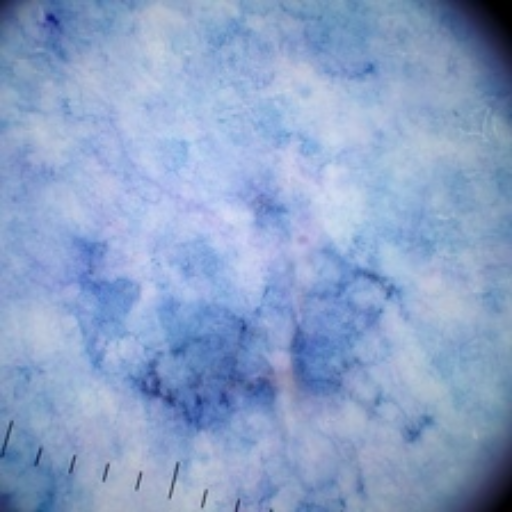

In [ ]:
imshow(img)

In [ ]:
loaded_model.predict(img)

NameError: ignored